# RNN in TensorFlow Keras - TimeSeries Data <a class="tocSkip">

In [1]:
import math
import os

import numpy as np
np.random.seed(123)
print("NumPy:{}".format(np.__version__))

import pandas as pd
print("Pandas:{}".format(pd.__version__))

import sklearn as sk
from sklearn import preprocessing as skpp
print("sklearn:{}".format(sk.__version__))

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update(
    {
        'font.size': 20,
        'figure.figsize': [15,10] 
    }
)
print("Matplotlib:{}".format(matplotlib.__version__))

import tensorflow as tf
tf.set_random_seed(123)
print("TensorFlow:{}".format(tf.__version__))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, SimpleRNN, GRU

# ⚠️⚠️⚠️ Note these extremely weird imports!:
from tensorflow.keras.losses import mean_squared_error as k_mse
from tensorflow.keras.backend import sqrt as k_sqrt
import tensorflow.keras.backend as K

import tensorflow.keras as keras
print("Keras:{}".format(keras.__version__))

NumPy:1.18.5
Pandas:1.2.4
sklearn:0.24.2
Matplotlib:3.3.4
TensorFlow:1.15.5
Keras:2.2.4-tf


In [2]:
DATASETSLIB_HOME = '../datasetslib'
import sys

if not DATASETSLIB_HOME in sys.path:
    sys.path.append(DATASETSLIB_HOME)

%reload_ext autoreload
%autoreload 2

import datasetslib
from datasetslib import util as dsu
datasetslib.datasets_root = os.path.abspath('../datasets')

# Read and pre-process the dataset

In [3]:
filepath = os.path.join(
    datasetslib.datasets_root,
    'ts-data',
    'international-airline-passengers.csv'
) 

dataframe = pd.read_csv(
    filepath,
    usecols=[1],
    header=0
).dropna()

dataset = dataframe.values
dataset = dataset.astype(np.float32)

In [4]:
# normalize the dataset
scaler = skpp.MinMaxScaler(feature_range=(0, 1))
normalized_dataset = scaler.fit_transform(dataset)

In [5]:
# split into train and test sets
train, test = dsu.train_test_split(normalized_dataset, train_size=0.67)

n_x = 1
X_train, Y_train, X_test, Y_test = dsu.mvts_to_xy(train, test, n_x=n_x, n_y=1)

In [6]:
print(X_train.shape)
print(X_train[0:5])
print(Y_train.shape)
print(Y_train[0:5])

print("---")

print(X_test.shape)
print(X_test[0:5])
print(Y_test.shape)
print(Y_test[0:5])

(95, 1)
[[0.01544401]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]]
(95, 1)
[[0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]
 [0.05984557]]
---
(47, 1)
[[0.4073359 ]
 [0.3803089 ]
 [0.48648646]
 [0.47104248]
 [0.484556  ]]
(47, 1)
[[0.3803089 ]
 [0.48648646]
 [0.47104248]
 [0.484556  ]
 [0.6138996 ]]


# Keras SimpleRNN for TimeSeries Data

#### Note on data shape
For Keras, the input has to be in the shape `(samples, time_steps, features)`

In [7]:
tf.reset_default_graph()
keras.backend.clear_session()

In [8]:
# reshape input to be [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_train.shape[1], 1)

In [9]:
print(X_train.shape)
print(X_train[0:5])
print(Y_train.shape)
print(Y_train[0:5])

print("---")

print(X_test.shape)
print(X_test[0:5])
print(Y_test.shape)
print(Y_test[0:5])

(95, 1, 1)
[[[0.01544401]]

 [[0.02702703]]

 [[0.05405405]]

 [[0.04826255]]

 [[0.03281853]]]
(95, 1)
[[0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]
 [0.05984557]]
---
(47, 1, 1)
[[[0.4073359 ]]

 [[0.3803089 ]]

 [[0.48648646]]

 [[0.47104248]]

 [[0.484556  ]]]
(47, 1)
[[0.3803089 ]
 [0.48648646]
 [0.47104248]
 [0.484556  ]
 [0.6138996 ]]


### ⚠️ This preprocessing makes no sense to me in context of this dataset! I guess they're using 1 time step sequences 🤷.

In [10]:
# create and fit the SimpleRNN model
model = Sequential()
model.add(SimpleRNN(units=4, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.fit(X_train, Y_train, epochs=20, batch_size=1)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 4)                 24        
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________
Train on 95 samples
Epoch 1/20
95/95 [==============================] - 1s 8ms/sample - loss: 0.0449
Epoch 2/20
95/95 [==============================] - 0s 1ms/sample - loss: 0.0179
Epoch 3/20
95/95 [==============================] - 0s 1ms/sample - loss: 0.0147
Epoch 4/20
95/95 [==============================] - 0s 1ms/sample - loss: 0.0124
Epoch 5/20
95/95 [==============================] - 0s 1ms/sample - loss: 0.0102
Epoch 6/20
95/95

In [11]:
# make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

# invert originals
y_train_orig = scaler.inverse_transform(Y_train)
y_test_orig = scaler.inverse_transform(Y_test)

# calculate root mean squared error
# ⚠️ Note the passing of session and use of weird imports from above!
trainScore = k_sqrt(
    k_mse(y_train_orig[:,0], y_train_pred[:,0])
).eval(session=K.get_session())
print('Train Score: {0:.2f} RMSE'.format(trainScore))

testScore = k_sqrt(
    k_mse(y_test_orig[:,0], y_test_pred[:,0])
).eval(session=K.get_session())
print('Test Score: {0:.2f} RMSE'.format(testScore))

Train Score: 22.88 RMSE
Test Score: 52.87 RMSE


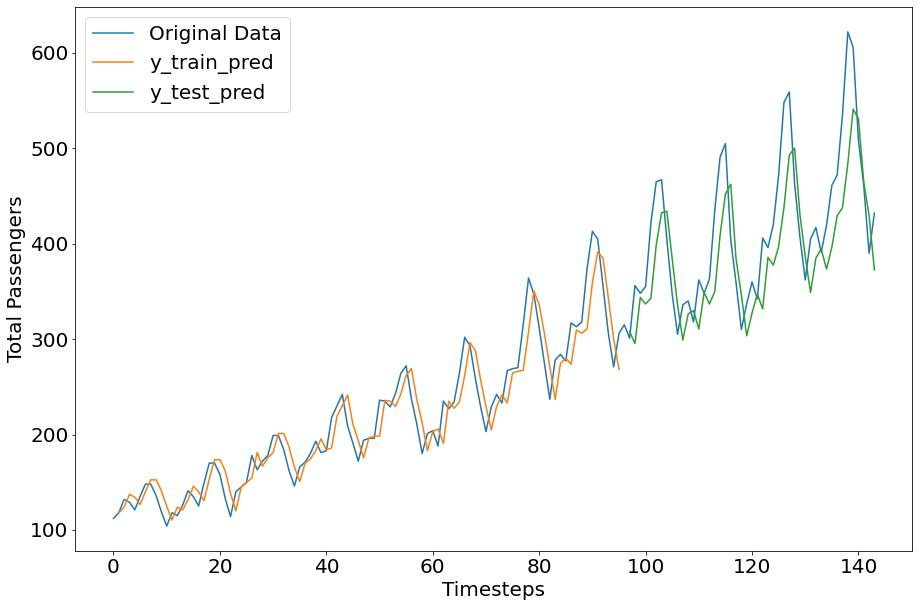

In [12]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(normalized_dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[n_x:len(y_train_pred)+n_x, :] = y_train_pred
# shift test predictions for plotting
testPredictPlot = np.empty_like(normalized_dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+(n_x*2):len(normalized_dataset),:]=y_test_pred
# plot baseline and predictions
plt.plot(scaler.inverse_transform(normalized_dataset),label='Original Data')
plt.plot(trainPredictPlot,label='y_train_pred')
plt.plot(testPredictPlot,label='y_test_pred')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Total Passengers')
plt.show()

# Keras LSTM for TimeSeries Data

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4)                 96        
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 95 samples
Epoch 1/20
95/95 [==============================] - 1s 6ms/sample - loss: 0.0378
Epoch 2/20
95/95 [==============================] - 0s 2ms/sample - loss: 0.0176
Epoch 3/20
95/95 [==============================] - 0s 2ms/sample - loss: 0.0142
Epoch 4/20
95/95 [==============================] - 0s 2ms/sample - loss: 0.0129
Epoch 5/20
95/95 [==============================] - 0s 2ms/sample - loss: 0.0118
E

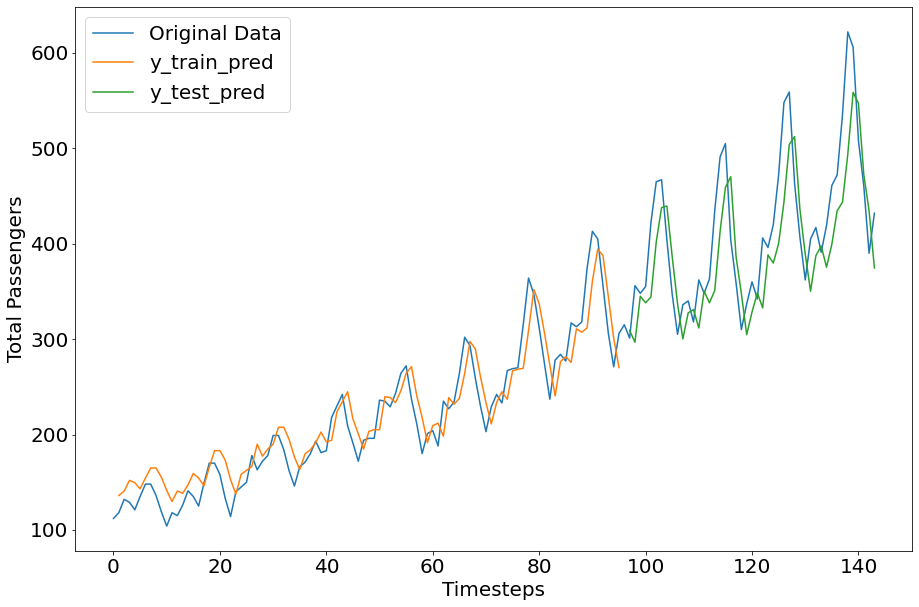

In [13]:
tf.reset_default_graph()
keras.backend.clear_session()

# reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0], X_train.shape[1], 1)

# create and fit the LSTM model
model = Sequential()
model.add(LSTM(units=4, input_shape=(X_train.shape[1], X_train.shape[2])))  # <--- DIFFERENCE HERE
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.fit(X_train, Y_train, epochs=20, batch_size=1)

# make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

# invert originals
y_train_orig = scaler.inverse_transform(Y_train)
y_test_orig = scaler.inverse_transform(Y_test)

# calculate root mean squared error
trainScore = k_sqrt(k_mse(y_train_orig[:,0],
                          y_train_pred[:,0])
                   ).eval(session=K.get_session())
print('Train Score: {0:.2f} RMSE'.format(trainScore))
testScore = k_sqrt(k_mse(y_test_orig[:,0],
                         y_test_pred[:,0])
                  ).eval(session=K.get_session())
print('Test Score: {0:.2f} RMSE'.format(testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(normalized_dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[n_x:len(y_train_pred)+n_x, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(normalized_dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+(n_x*2):len(normalized_dataset), :] = y_test_pred

# plot baseline and predictions
plt.plot(scaler.inverse_transform(normalized_dataset),label='Original Data')
plt.plot(trainPredictPlot,label='y_train_pred')
plt.plot(testPredictPlot,label='y_test_pred')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Total Passengers')
plt.show()

# Keras GRU for TimeSeries Data

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 4)                 72        
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 77
Trainable params: 77
Non-trainable params: 0
_________________________________________________________________
Train on 95 samples
Epoch 1/20
95/95 [==============================] - 0s 5ms/sample - loss: 0.0260
Epoch 2/20
95/95 [==============================] - 0s 2ms/sample - loss: 0.0112
Epoch 3/20
95/95 [==============================] - 0s 2ms/sample - loss: 0.0094
Epoch 4/20
95/95 [==============================] - 0s 2ms/sample - loss: 0.0084
Epoch 5/20
95/95 [==============================] - 0s 2ms/sample - loss: 0.0076
Epoch 6/20
95/95 [==============================] - 0s 2ms/sample - loss: 0.0065
Epoch 7/20
95/95

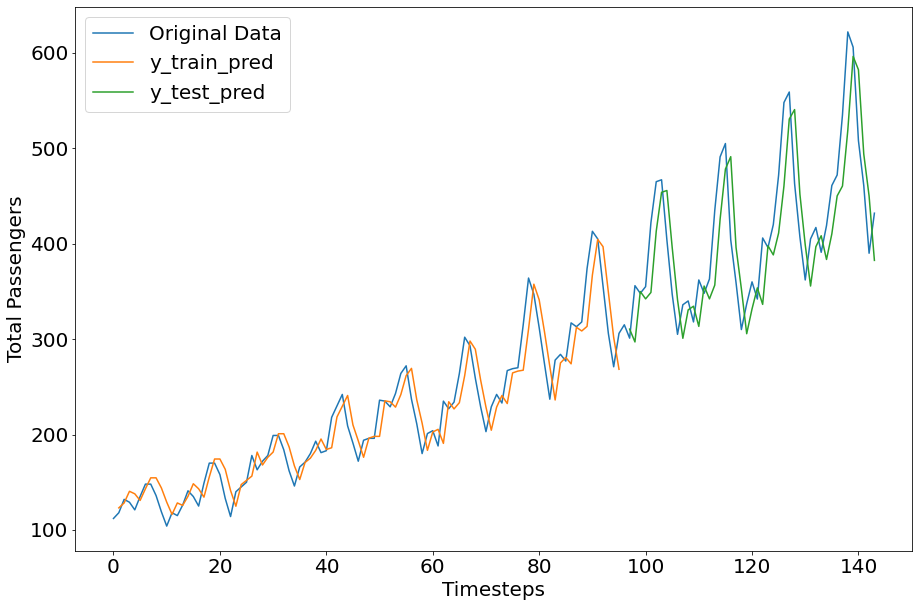

In [14]:
tf.reset_default_graph()
keras.backend.clear_session()

# reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0], X_train.shape[1], 1)

# create and fit the GRU Model
model = Sequential()
model.add(GRU(units=4, input_shape=(X_train.shape[1], X_train.shape[2])))  # <--- DIFFERENCE HERE
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.fit(X_train, Y_train, epochs=20, batch_size=1)

# make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

#invert originals
y_train_orig = scaler.inverse_transform(Y_train)
y_test_orig = scaler.inverse_transform(Y_test)

# calculate root mean squared error
trainScore = k_sqrt(k_mse(y_train_orig[:,0],
                          y_train_pred[:,0])
                   ).eval(session=K.get_session())
print('Train Score: {0:.2f} RMSE'.format(trainScore))
testScore = k_sqrt(k_mse(y_test_orig[:,0],
                         y_test_pred[:,0])
                  ).eval(session=K.get_session())
print('Test Score: {0:.2f} RMSE'.format(testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(normalized_dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[n_x:len(y_train_pred)+n_x, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(normalized_dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+(n_x*2):len(normalized_dataset), :] = y_test_pred

# plot baseline and predictions
plt.plot(scaler.inverse_transform(normalized_dataset),label='Original Data')
plt.plot(trainPredictPlot,label='y_train_pred')
plt.plot(testPredictPlot,label='y_test_pred')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Total Passengers')
plt.show()